In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2

import pandas as pd
import ntpath
import random

In [2]:
datadir = 'track1+track2'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/var/folders/v3/hwmt_9nx6nl41f06plb5szqr0000gn/T/ipykernel_2775/2466686808.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,center,left,right,steering,throttle,reverse,speed
0,/Users/jonathanhu/Desktop/IMG/center_2024_05_08_09_45_11_973.jpg,/Users/jonathanhu/Desktop/IMG/left_2024_05_08_09_45_11_973.jpg,/Users/jonathanhu/Desktop/IMG/right_2024_05_08_09_45_11_973.jpg,0.0,0.0,0,0.000080
1,/Users/jonathanhu/Desktop/IMG/center_2024_05_08_09_45_12_096.jpg,/Users/jonathanhu/Desktop/IMG/left_2024_05_08_09_45_12_096.jpg,/Users/jonathanhu/Desktop/IMG/right_2024_05_08_09_45_12_096.jpg,0.0,0.0,0,0.000080
2,/Users/jonathanhu/Desktop/IMG/center_2024_05_08_09_45_12_212.jpg,/Users/jonathanhu/Desktop/IMG/left_2024_05_08_09_45_12_212.jpg,/Users/jonathanhu/Desktop/IMG/right_2024_05_08_09_45_12_212.jpg,0.0,0.0,0,0.000081
3,/Users/jonathanhu/Desktop/IMG/center_2024_05_08_09_45_12_328.jpg,/Users/jonathanhu/Desktop/IMG/left_2024_05_08_09_45_12_328.jpg,/Users/jonathanhu/Desktop/IMG/right_2024_05_08_09_45_12_328.jpg,0.0,0.0,0,0.000079
4,/Users/jonathanhu/Desktop/IMG/center_2024_05_08_09_45_12_446.jpg,/Users/jonathanhu/Desktop/IMG/left_2024_05_08_09_45_12_446.jpg,/Users/jonathanhu/Desktop/IMG/right_2024_05_08_09_45_12_446.jpg,0.0,0.0,0,0.000080


In [3]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2024_05_08_09_45_11_973.jpg,left_2024_05_08_09_45_11_973.jpg,right_2024_05_08_09_45_11_973.jpg,0.0,0.0,0,0.000080
1,center_2024_05_08_09_45_12_096.jpg,left_2024_05_08_09_45_12_096.jpg,right_2024_05_08_09_45_12_096.jpg,0.0,0.0,0,0.000080
2,center_2024_05_08_09_45_12_212.jpg,left_2024_05_08_09_45_12_212.jpg,right_2024_05_08_09_45_12_212.jpg,0.0,0.0,0,0.000081
3,center_2024_05_08_09_45_12_328.jpg,left_2024_05_08_09_45_12_328.jpg,right_2024_05_08_09_45_12_328.jpg,0.0,0.0,0,0.000079
4,center_2024_05_08_09_45_12_446.jpg,left_2024_05_08_09_45_12_446.jpg,right_2024_05_08_09_45_12_446.jpg,0.0,0.0,0,0.000080


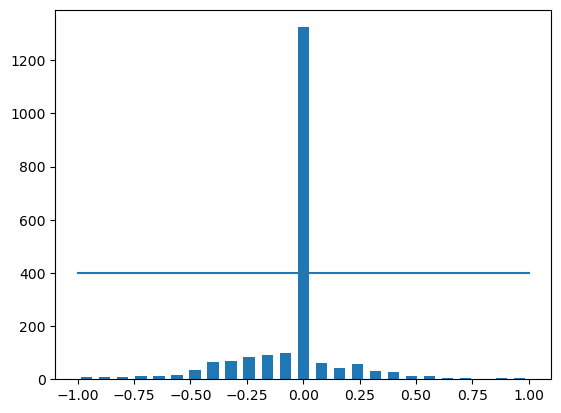

In [4]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [5]:

print('total data:', len(data))
print(data.shape)

total data: 2095
(2095, 7)


In [6]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 924
remaining: 1171


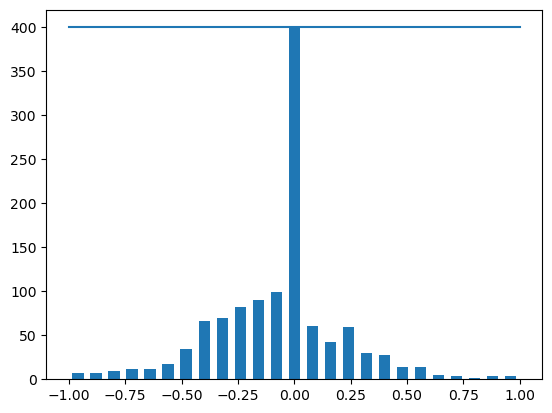

In [7]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [8]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

In [9]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [10]:
len(image_paths)

3513

In [11]:
len(steerings)

3513

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
     

Training Samples: 2810
Valid Samples: 703


Text(0.5, 1.0, 'Validation set')

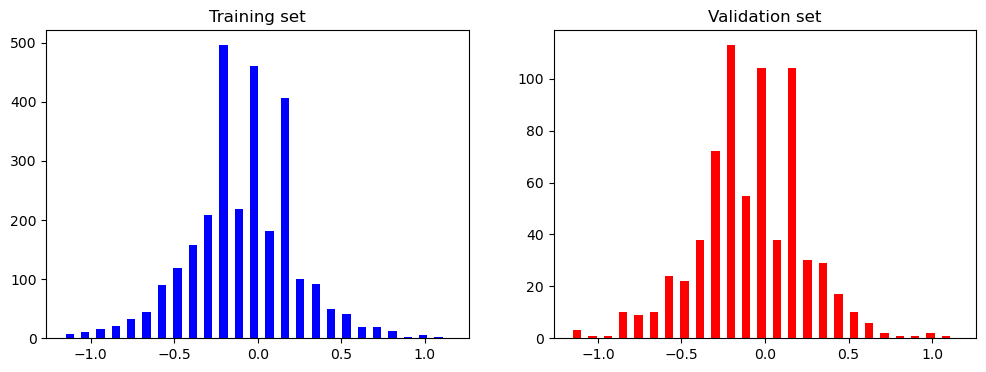

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [14]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

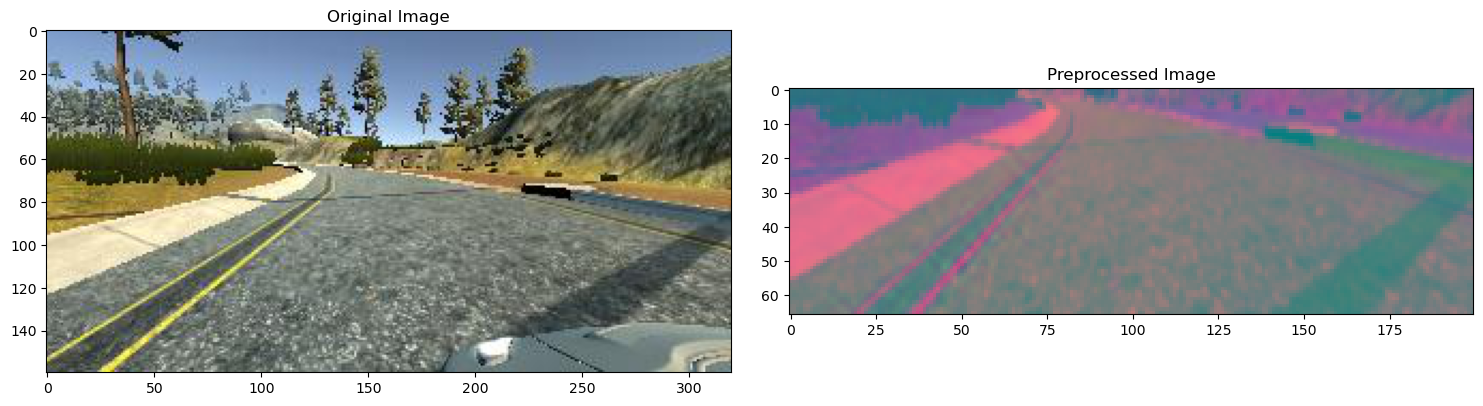

In [15]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [16]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [22]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      im = mpimg.imread(image_paths[random_index])
      steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [23]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

Text(0.5, 1.0, 'Validation Image')

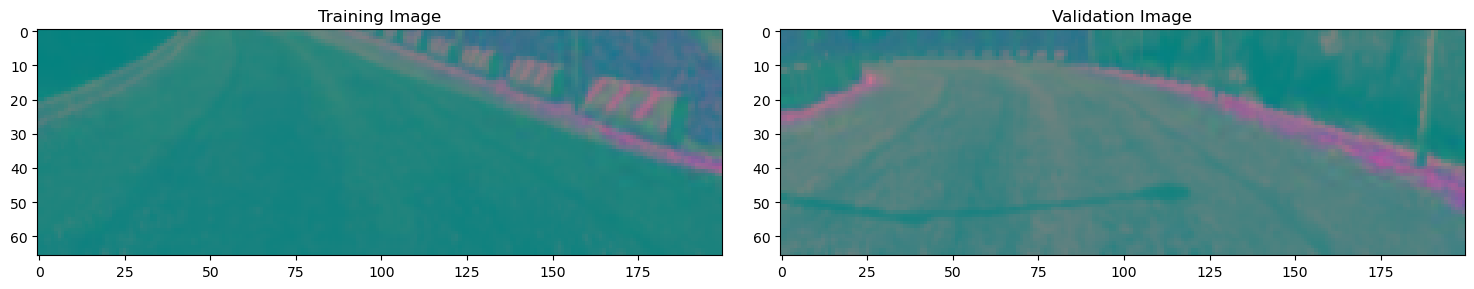

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [26]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), activation='elu'))
  # model.add(Conv2D(64, (3,3), activation='elu'))
#   model.add(Dropout(0.5))


  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = nvidia_model()
print(model.summary())

2024-05-08 09:55:25.317202: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-05-08 09:55:25.317235: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-08 09:55:25.317239: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-08 09:55:25.317364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-08 09:55:25.317412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 18, 64)         76864     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               115300    
                                                                 
 dense_1 (Dense)             (None, 50)                5

In [27]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10


2024-05-08 09:55:44.054082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 40s 133ms/step - loss: 0.0868 - val_loss: 0.0485
Epoch 2/10
300/300 [==============================] - 40s 133ms/step - loss: 0.0393 - val_loss: 0.0406
Epoch 3/10
300/300 [==============================] - 42s 139ms/step - loss: 0.0288 - val_loss: 0.0382
Epoch 4/10
300/300 [==============================] - 43s 145ms/step - loss: 0.0196 - val_loss: 0.0377
Epoch 5/10
300/300 [==============================] - 43s 142ms/step - loss: 0.0129 - val_loss: 0.0372
Epoch 6/10
300/300 [==============================] - 43s 144ms/step - loss: 0.0076 - val_loss: 0.0399
Epoch 7/10
300/300 [==============================] - 40s 134ms/step - loss: 0.0041 - val_loss: 0.0418
Epoch 8/10
300/300 [==============================] - 41s 136ms/step - loss: 0.0025 - val_loss: 0.0426
Epoch 9/10
300/300 [==============================] - 40s 134ms/step - loss: 0.0015 - val_loss: 0.0412
Epoch 10/10
300/300 [==============================] - 40s 135ms/step - loss: 0.0016

Text(0.5, 0, 'Epoch')

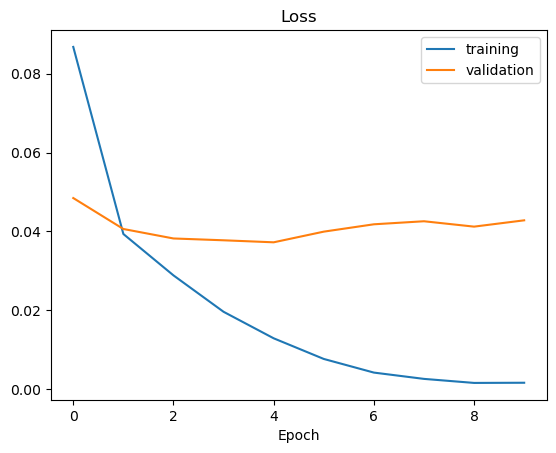

In [28]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')


In [30]:
model.save('model/two_tracks_no_data_aug_no_drop_out.h5')

/Users/jonathanhu/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
